# NOTE TO THE EVALUATOR, PLEASE READ

The notebook takes data from a local directory namely <code>folder_path = './Assignment3_dataset/' </code>. It was suggested in the course discussion forum to upload data along with the notebook. As the dataset provided was of 82 MB , it was impossible to upload it on moodle(Limit exceded).<br><br>
This code will run properly in any directory where the extracted folder <code>Assignment3_dataset</code> is present. Futhermore All the plots and images are already presented by submittiong the executed notebook.<br><br>
All the imports that are used in this notebook are colledted together in the Import subsection below. All these imported smoothly on Google Collab and no error or requirement is shown.

# Imports

In [ ]:
import torch
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

import argparse
import os
import random

import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data import Subset
from torchvision.transforms import InterpolationMode
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split


# Helper Functions

In [ ]:
def plot_images(X, batch=True, save=False, title='one'):
    
    """
    Plots batch of images as well as normal single image 
    Input is X : torch tensor : shape batch x 3 x h x w
    """
    
    if batch:
        # Assuming you have a batch of images with shape Bx3x64x64
        num_cols = 8  # Specify the number of rows and columns in the grid
        num_rows = len(X)//num_cols if len(X)//num_cols else 1 

        # Create a figure and a grid of subplots to display the images
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))

        # Iterate through the batch and plot each image in the grid
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                image = X[idx].permute(1, 2, 0).numpy()  # Convert to HxWxC format
                axs[i, j].imshow((image*255).astype("uint8"))
                axs[i, j].axis('off')

        # Adjust spacing and layout
        # Reduce spacing between subplots
        plt.subplots_adjust(wspace=0.025, hspace=0.025)
        
        # Save the subplots as an image
        if save:
            plot_name = title + '.png' 
            plt.savefig(plot_name)
            
    else:
        # Note here X should be an image 3xhxw
        plt.figure(figsize=(2, 2))
        plt.imshow(np.transpose(X, (1, 2, 0)))

    # Show the plot
    plt.show()

In [ ]:
def compare_images(image1, image2, scale=1):
    
    # images are torch tensors
    image1 = np.transpose(image1.numpy(),(1,2,0))
    image2 = np.transpose(image2.numpy(),(1,2,0))
        
    # Create a new figure
    fig, axes = plt.subplots(1, 2, figsize=(scale*8, scale*4))  # Create a 1x2 grid of subplots

    # Plot image1 on the first subplot
    axes[0].imshow(image1)
    axes[0].axis('off')  # Turn off axis labels
    axes[0].set_title(f'Initial Image')

    # Plot image2 on the second subplot
    axes[1].imshow(image2)
    axes[1].axis('off')  # Turn off axis labels
    axes[1].set_title(f'Transformed Image')

    # Adjust spacing between the subplots
    plt.subplots_adjust(wspace=0.1)

    # Show the combined figure with both images side by side
    plt.show()
    

In [ ]:
def augment_data(X, plot=False):
    
    if plot:
        print("########## ORIGINAL IMAGES ##########")
        plot_images(X)

    # Gamma balance the image
    gamma = 1.8
    X_gamma =  torch.clamp(X * gamma, 0, 1)
    if plot:
        print("########## GAMMA IMAGES ##########")
        plot_images(X_gamma)

    # Sharpen the images
    X_sharper = torchvision.transforms.functional.adjust_sharpness(X_gamma, sharpness_factor=3.5)
    if plot:
        print("########## SHARPER IMAGES ##########")
        plot_images(X_sharper)

    # Rotate the images +5
    X_rotated_plus = torchvision.transforms.functional.rotate(X_sharper,angle=5, interpolation= InterpolationMode.BILINEAR)
    if plot:
        print("########## +5 ROTATED IMAGES ##########")
        plot_images(X_rotated_plus)

    # Rotate the images -5
    X_rotated_minus = torchvision.transforms.functional.rotate(X_sharper,angle=-5, interpolation= InterpolationMode.BILINEAR)
    if plot:
        print("########## -5 ROTATED IMAGES ##########")
        plot_images(X_rotated_minus) 

    # Concatenate images
    X_out = torch.cat((X_sharper, X_rotated_plus, X_rotated_minus), dim=0)

    # Flip the images
    X_flipped = torchvision.transforms.functional.hflip(X_sharper)
    if plot:
        print("########## FLIPPED IMAGES ##########")
        plot_images(X_flipped) 

    # Rotate the flipped images +5
    X_flipped_rotated_plus = torchvision.transforms.functional.rotate(X_flipped ,angle=5, interpolation= InterpolationMode.BILINEAR)
    if plot:
        print("########## FLIPPED +5 ROTATED IMAGES ##########")
        plot_images(X_flipped_rotated_plus)

    # Rotate the flipped images -5
    X_flipped_rotated_minus = torchvision.transforms.functional.rotate(X_flipped ,angle=-5, interpolation= InterpolationMode.BILINEAR)
    if plot:
        print("########## FLIPPED -5 ROTATED IMAGES ##########")
        plot_images(X_flipped_rotated_minus)

    # Concatenate images
    X_out = torch.cat((X_out , X_flipped, X_flipped_rotated_plus, X_flipped_rotated_minus), dim=0)
    
    return X_out
    

In [ ]:
def seed_all(seed_val=42):
    # Set the seed for the random number generator in PyTorch
    torch.manual_seed(seed_val)

    # Set the seed for the random number generator in the Python standard library (random module)
    random.seed(seed_val)

    # Set the seed for the random number generator in NumPy
    np.random.seed(seed_val)

    # Set the seed for the CUDA (GPU) operations if you are using GPUs
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

    # Additional configurations for deterministic behavior (not always necessary)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# PROBLEM STATEMENT
## For this question, choose a different object category K, different from C chosen in the previous question. Construct a data set D1 containing 90% images from the category K of the data. Construct a validation set V1 using the remaining 10% images. This question is about constructing a VAE to generate images similar to those in category K. Please note that you need to choose only a single object category for this exercise. Answers generating all three categories of objects will not be considered.

### Read Folder Path and image Paths

In [ ]:
chosen_class = 'boat'     # Choose Category 'boat' 'bus' or 'car' (here K)
desired_width = 64
desired_height = 64
folder_path = './Assignment3_dataset/' 

class_names = os.listdir(folder_path)   # A list of images in folder path
print(f'Total classes in folder : {len(class_names)}')

### Read All Images in the folder

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")

In [ ]:
# Create the dataset
dataset = datasets.ImageFolder(root=folder_path,
                               transform=transforms.Compose([
                               transforms.Resize((desired_height,desired_width)),
                               transforms.ToTensor(),
                           ]))


# Filter data according to desired class
print(f'Class to id dictionary : {dataset.class_to_idx}')
chosen_class_id = dataset.class_to_idx[chosen_class]
print(f'Index of the desired class : {chosen_class_id} ')

class_indices = []
for i in range(len(dataset)):
    if dataset.imgs[i][1]==chosen_class_id:
        class_indices.append(i)
subset = Subset(dataset, class_indices)

all_data = []
for idx in range(len(subset)):
    data, target = subset[idx]
    all_data.append((data, target))

d_loader = DataLoader(subset, batch_size=len(subset))
for batch in d_loader:
    X_all, _ = batch  # data and target are torch tensors


In [ ]:
print("#################### SOME IMAGES FOR THE CATEGORY ####################")
plot_images(X_all[:16])

### 90-10 split the images

## SOL : DATASET D1 and V1

In [ ]:

D1, V1 = train_test_split(X_all, test_size=0.1, random_state=42)
print(f"Images in the train set D1 : {D1.shape[0]}")
print(f"Images in the test set V1 : {V1.shape[0]}")

In [ ]:
# Augment DATA for Training and Testing 
# Toggle 'plot=True' for viauslisation of augnemtations
X_train = augment_data(D1, plot=False)
X_train = X_train[:576] 
X_val = augment_data(V1, plot=False)
X_val_norm = 2 * X_val - 1
X_val_norm  = X_val_norm.to(device)

______________
# (a)
## Construct a suitable VAE architecture using convolutions and related operations (e.g. upsampling, pooling, batch normalization etc). You can use the demo code posted in moodle to construct your VAE. You are free to use other CNN architectures for your VAE based on the requirements of the data set. If you choose a different architecure, you must clearly justify your choice for the same.
_______________

## SOL (a) : Constructed VAE below : Please note that this is the same architecture as presented in the implementation provided. Only a new function is added to generate images. Also the code is written in a little modular way

In [ ]:
class VAE(nn.Module):

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims = None,
                 kld_w = 0.00025):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.kld_w = kld_w 

        modules = []
        if hidden_dims is None:
            #hidden_dims = [32, 64, 128, 256, 512]
            hidden_dims = [32, 64, 128]
            

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        # 4 comes from 2x2
        # self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        # self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)
        
        self.fc_mu = nn.Linear(hidden_dims[-1]*64, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*64, latent_dim)

        
        
        # Build Decoder
        modules = []

        #self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 64)
        

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, x):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        # 2,2 comes from 2x2
        #result = result.view(-1, 512, 2, 2)
        result = result.view(-1, 128, 8, 8)
        
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), x, mu, log_var]

    def loss_function(self, args):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        
        kld_weight = self.kld_w # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self, num_samples, current_device):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x):
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

______________
# (b)
## Train the VAE on the data D1 .
_______________

In [ ]:
max_epochs = 1000 
patience = 120  # Number of epochs to wait for improvement

In [ ]:
train_losses = []
plot_idx=0
for LR in [.001]:
    for KLD_WEIGHT in [5e-5]:
        
        plot_idx +=1
        title_x = str(plot_idx) + f"_LR={LR}__KLD_WEIGHT={KLD_WEIGHT}__real"
        title_recon = str(plot_idx) + f"_LR={LR}__KLD_WEIGHT={KLD_WEIGHT}__recon"
        title_gen = str(plot_idx) + f"_LR={LR}__KLD_WEIGHT={KLD_WEIGHT}__sampled"
        
        
        seed_all(seed_val=42)
        model = VAE(in_channels=3, latent_dim=256, kld_w=KLD_WEIGHT).to(device)
        
        optimizer_vae = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)
        # Define the learning rate scheduler
        step_size = 10  # Adjust this according to your training schedule
        gamma = 0.95  # Factor by which the learning rate is reduced
        scheduler = StepLR(optimizer_vae, step_size=step_size, gamma=gamma)

        
        train_loader = DataLoader(X_train, batch_size=64, shuffle=True)
        
        
        
        best_test_loss = float('inf')
        for epoch in range(max_epochs):

            train_loss = 0
            recon_loss = 0
            kl_loss = 0
            recon_batch = None

            model.train()
            for batch_idx, X_batch in enumerate(train_loader):


                X_norm = 2 * X_batch - 1
                X_norm = X_norm.to(device)

                optimizer_vae.zero_grad()
                decoded, x, mu, log_var = model(X_norm)
                arr = [decoded, x, mu, log_var]

                loss_dict = model.loss_function(arr)

                reconstruction_loss = loss_dict['Reconstruction_Loss']
                recon_loss += reconstruction_loss

                kl_divergence_loss = loss_dict['KLD']
                kl_loss += kl_divergence_loss

                loss = loss_dict['loss']
                loss.backward()

                train_loss += loss.item()

                optimizer_vae.step()
            
            train_losses.append(train_loss)
            
            # After Every Epoch
            scheduler.step()

            ##### USING VALIDATION SET #####

            model.eval()
            
            
            if epoch%25==0:
                
                with torch.no_grad():
                
                    

                    print(f'EPOCH : {epoch+1}')
                    print(f'RECON LOSS : {reconstruction_loss} --- KL LOSS : {kl_divergence_loss} --- LOSS : {loss.item()}')
                    print("######################## STILL TRAINING ########################")

                    print("####################### INPUT IMAGES #######################")
                    plot_images((((X_norm.detach().cpu())+1.0)/2.0)[:16])

                    print("####################### RECON IMAGES #######################")
                    recons = model.generate(X_norm).detach().cpu()
                    recons = (recons+1.0)/2.0
                    plot_images(recons[:16])

                    print("####################### GEN IMAGES #######################")
                    sampled = model.sample(num_samples=64, current_device=device)
                    plot_images((((sampled.detach().cpu())+1.0)/2.0)[:16])
                    
                    print("\n\n\n")

            
            
        
            
            
            with torch.no_grad():

                test_arr = model(X_val_norm.to(device))
                test_loss_dict = model.loss_function(test_arr)
                test_loss = test_loss_dict['loss'].item()

            if test_loss < best_test_loss:

                best_test_loss = test_loss
                patience_counter = 0

            else:
                patience_counter += 1

            if patience_counter >= patience:
                
                print(f"Early stopping after {epoch+1} epochs.")
                
                print(f'EPOCH : {epoch+1}')
                print(f'RECON LOSS : {reconstruction_loss} --- KL LOSS : {kl_divergence_loss} --- LOSS : {loss.item()}')

                model.eval()

                print("####################### INPUT IMAGES #######################")
                plot_images((((X_norm.detach().cpu())+1.0)/2.0)[:16])

                print("####################### RECON IMAGES #######################")
                recons = model.generate(X_norm).detach().cpu()
                recons = (recons+1.0)/2.0
                plot_images(recons[:16])

                print("####################### GEN IMAGES #######################")
                sampled = model.sample(num_samples=64, current_device=device)
                plot_images((((sampled.detach().cpu())+1.0)/2.0)[:16])

                
                
                print(f"Early stopping after {epoch+1} epochs.")
                print("\n\n\n")
                
                
                break
                
                

______________
# (c)
## Choose the best parameters for VAE (e.g. number of training iterations, learning rate, weightage for KL term, etc.) using the validation set V1 . You can use early stopping criteria and learning rate scheduling based on your choice.

# (d)
## Clearly describe in your python notebook about the training heuristics used in your code and explain why they were useful.
_______________

## SOL : (c) & SOL : (d)

1. A following code of the form below 
```
    for LR in [1e-4, 2e-4, 3e-4, 5e-4, .001, .002, .003, .005]:
        for KLD_WEIGHT in [.0001, .0002, .0005, .00075, .001, .002, .005]:
            model.train()
```
was used to search for the best Learning Rate and weightage for KL term . It is not shown here as the images requires a lot of space.<br><br>

2. Batch size were also experimented with  <code> batch_size=64</code> was found to be optimal <br><br>

3. Learning Rate Scheduling using <code>StepLR</code> was also done to fine tune the model. Please check the train code above to verify. <br><br>

4. Encoder of channels 3 --> 32 --> 64 --> 128 was used. An additional 32 channel layer was added to give more depth to network. This improved the generated quality of the images. <br><br>

5. Decoder of the same opposite order were used. The decoder used LeakyRelU as it gave better results, than ReLU. Also at the end a tanh() layer was added to let the image pixel value be in the domain [-1,1] <br><br>

6. Early Stopping was implemented usin the same loss function described for train data. The patience parameter was also tuned in order to get descent quality images.<br><br> 

7. BatchNorm was useful as before that the images were distorted, It is so because the input is in range [-1,1]. There for at every layer the activations should be normalised<br><br>
8. The training was done on the augmented dataset that had rotated(+5,-5) and flipped images. This helped increase the dataset size 

______________
# (e)
## Clearly describe the objective used for VAE and your training and inference procedures.
_______________

## SOL : (e) : Objective

The objective of VAE is made up of two parts : <br>
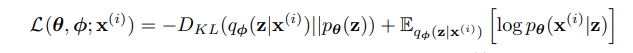
<br>
Now Note that :
$$KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
$$

So the KL divergence between q_phi and p_theta has a closed form as they both are normal <br><br>
The loss is therefore
```
recons_loss =F.mse_loss(recons, input)
kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

```
In order to tune the model a hyperparameter called <code>KLD_WEIGHT</code> is used. So the overall loss used is<br>
```
total_loss = recon_loss + KLD_WEIGHT X kld_loss
```
Please verify the claims in the <code> class VAE() </code> above

## SOL : (e) : Inference

The inference procedure for VAE is pretty straightforward. Once the VAE is trained, pure Gaussian random noise is passed through the VAE Decoder, and the Generated images are found. This is encapsulated in the function
```
def sample(self, num_samples, current_device):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples
```
which is a part of the VAE Class above.

______________
# (f)
## Prepare a plot of the training objective value against the iterations.
_______________

## SOL : (f) : Plot is shown below

In [ ]:
plt.figure(figsize=(12,6))
plt.grid()
plt.title("Train Loss vs Epochs", fontsize=20)
plt.plot(train_losses, marker='o')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Train Loss", fontsize=12)
plt.show()

______________
# (g)
## After training, display 10 images (in a 10 × 1 grid) generated using the VAE. For each of the 10 images, display 5 original images from the training data D1 closer to the generated image in a 10 × 5 grid. Comment on the quality of the generated images. Explain the similarity metric you used in the code and justify your choice.
_______________

## SOL : (g) : Note the 10x1 grid is drawn along side the closest generated image

Images can be visualised as nothing but vectors in a high dimensional space. Therefore it was mose natural to use the MSE distance of images as a similiarity metric. Two images are compared pixewise by substracting their distance squared and the summation is performed over all the pixels of the image. This is a simple yet effective technique as can be seen in the top5 grid below for each generated image.

In [ ]:
sampled = model.sample(num_samples=96, current_device=device)
X_10 = sampled[0:10]
X_10 = X_10.detach().cpu()

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(12,8))  # Adjust the figsize as needed
for i in range(10):
    image = ((X_10[i]+1.0)/2.0).permute(1, 2, 0).numpy()
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

In [ ]:
#### FILTER TOP 5 ########
top5 = []
for img in X_10:
    mse_score_liss = []
    for d_img in D1:
        mse_score = F.mse_loss(img, d_img)
        mse_score_liss.append(mse_score.item())

    top_5_indices = sorted(range(len(mse_score_liss)), key=lambda i: mse_score_liss[i], reverse=True)[:5]
    top5.append(top_5_indices)

In [ ]:
#### GENERATE ALL IMAGES ########
all_images = []
for idx in range(len(X_10)):
    all_images.append(X_10[idx])
    for d_img in D1[top5[idx]]:
        all_images.append(d_img)
        
all_images = torch.stack(all_images)

In [ ]:


# Sample PyTorch tensor with 60 images shaped 60x3x64x64
images = all_images

# Create a figure and axis for plotting
fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(5, 10))

for i in range(10):
    for j in range(6):
        ax = axes[i, j]
        idx = i * 6 + j
        image = images[idx].permute(1, 2, 0).numpy()

        if j == 0:
            # For the first image in each row, add a thick black outline
            ax.imshow((image+1.0)/2.0)
            rect = plt.Rectangle((0, 0), 64, 64, linewidth=8, edgecolor='black', facecolor='none')
            ax.add_patch(rect)
        else:
            ax.imshow(image)
        if j==0:
            ax.set_title(f'Generated', fontsize=10)
        else:
            ax.set_title(f'Closest{j%6}', fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()


______________
# (f)
## IMPORTANT: Make sure that your VAE is useful for generating real-looking images. Answers having no meaningful image generation will not be considered for evaluation.
_______________

Below are the generated images for the trained VAE, please note that these were obtained after a lot of trial and error. Although not very sharphly but some of them do resemble BOAT class

In [ ]:

plot_images((((sampled.detach().cpu())+1.0)/2.0)[:40])

_____
# ###############THANK YOU###############
_____